<a href="https://colab.research.google.com/github/RoboMaroof/LLM-Applications-Building-Blocks/blob/main/Transformer_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Parts taken from [notebook](https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing#scrollTo=EDarxEWIRMKq) and [video](https://www.youtube.com/watch?v=kCc8FmEb1nY&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=8) on GPT by Andrej Karpathy

In [1]:
import torch

# Building Blocks

# Self-Attention

## Mathematical Background

In [2]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


# Single Head Attention

In [ ]:
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch size, time/token/context size, number of channels/dimensions
x = torch.randn(B,T,C)

head_size = 16 # hyperparameter of Attention head
key = nn.Linear(C, head_size, bias=False)   # Represents "What do I contain"
query = nn.Linear(C, head_size, bias=False)  # Represents "What am I looking for"
value = nn.Linear(C, head_size, bias=False)

# All tokens in all positions in B x T arrangement produces Key and Query vectors independently and in parallel at the same time wihout any communication with each other.
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)

# Coomunication happens here with queries looking for affinities or matching keys
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf')) # The only difference in Encoder block is that this line is absent so that tokens can communicate with futeure tokens.
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v

out.shape

### Intuition

Every single token at [B, T] emits 2 vectors:

**Input (x)  [B, T, C]**  : Input to single head

**Query (q)  [B, T, 16]**      : Represents "What am I looking for"

**Key   (k)  [B, T, 16]**       : Represents "What do I contain"

**Weight (wei) [B, T, T]**:
*   Dot product of **Query** and **Key**.
*   Represents weightage or attention scores.
*   When the **Query** and **Key** align, dot product gives a high number thereby a high weightage.

**Value  (v) [B, T, 16]**: Represetns "What I will communicate"

**Output (out) [B, T, 16]**: Output from single head --> Attention

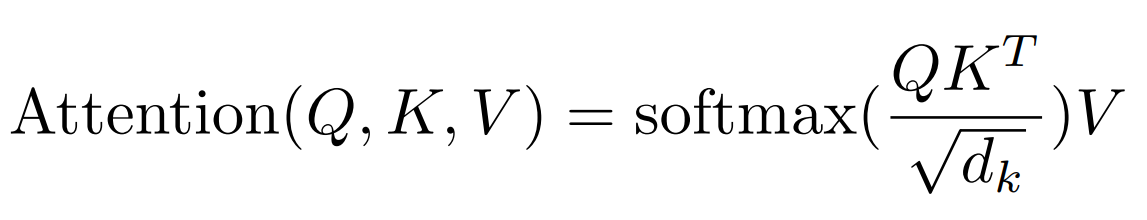

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much.

### Single Head Implementation

In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out


# Multi-Head Attention

## Intuition

Multiple Attetnions in parallel and concatenating the results over channel dimension.

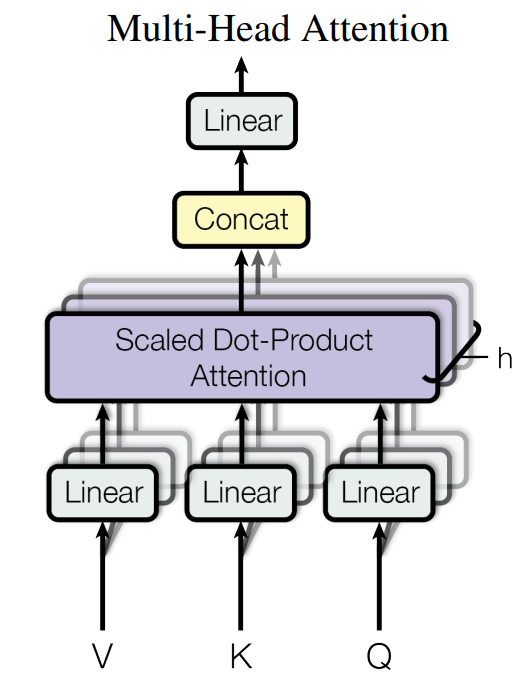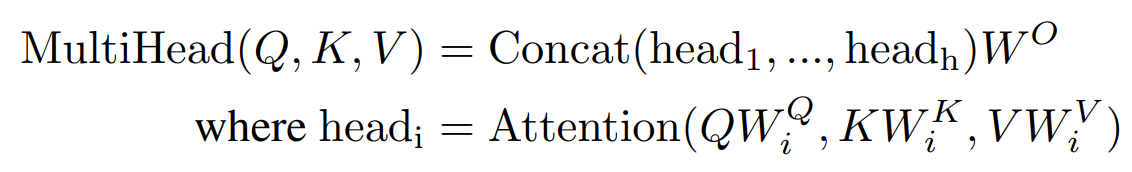

## Implementation

In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # Concatenation over channel dimension
        out = self.dropout(self.proj(out))
        return out

# Feed Forward Network (FFN)

## Intuition

A simple Multi Layer Perceptron (MLP).

To allow the tokens to "think on" what they found from other tokens in Multi-Head Attention.

All tokens do this independently (unlike Self-Attention where there is communication among tokens)

* Attention --> Communicate

* FFN --> Compute

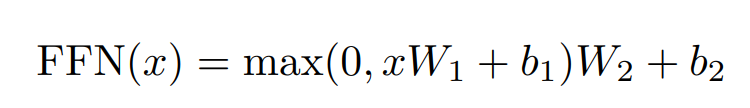

## Implementation

In [ ]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

# Block